In [ ]:
from google.colab import drive
drive.mount('/Dataset')

Mounted at /Dataset


In [ ]:
import os
os.chdir("/Dataset/MyDrive/fingers")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os

In [ ]:
trainpaths = os.listdir("/Dataset/MyDrive/fingers/train")
testpaths = os.listdir("/Dataset/MyDrive/fingers/test")

all_files_train = ["/Dataset/MyDrive/fingers/train/" + i for i in trainpaths]
all_files_test = ["/Dataset/MyDrive/fingers/test/" + i for i in testpaths]

In [ ]:
train_df = pd.DataFrame(all_files_train, columns=['Filepath'])
test_df = pd.DataFrame(all_files_test, columns=['Filepath'])

train_df.head()

,Filepath
0,/Dataset/MyDrive/fingers/train/f6461066-2d17-4...
1,/Dataset/MyDrive/fingers/train/ed6d1c31-2c20-4...
2,/Dataset/MyDrive/fingers/train/ebc9bee0-b234-4...
3,/Dataset/MyDrive/fingers/train/f2a43060-e665-4...
4,/Dataset/MyDrive/fingers/train/fef9f07e-8eee-4...


In [ ]:
train_df['Label'] = train_df['Filepath'].apply(lambda a: a[-6:-4])
test_df['Label'] = test_df['Filepath'].apply(lambda a: a[-6:-4])

In [ ]:
train_df.head()

,Filepath,Label
0,/Dataset/MyDrive/fingers/train/f6461066-2d17-4...,2L
1,/Dataset/MyDrive/fingers/train/ed6d1c31-2c20-4...,5L
2,/Dataset/MyDrive/fingers/train/ebc9bee0-b234-4...,0L
3,/Dataset/MyDrive/fingers/train/f2a43060-e665-4...,0R
4,/Dataset/MyDrive/fingers/train/fef9f07e-8eee-4...,1R


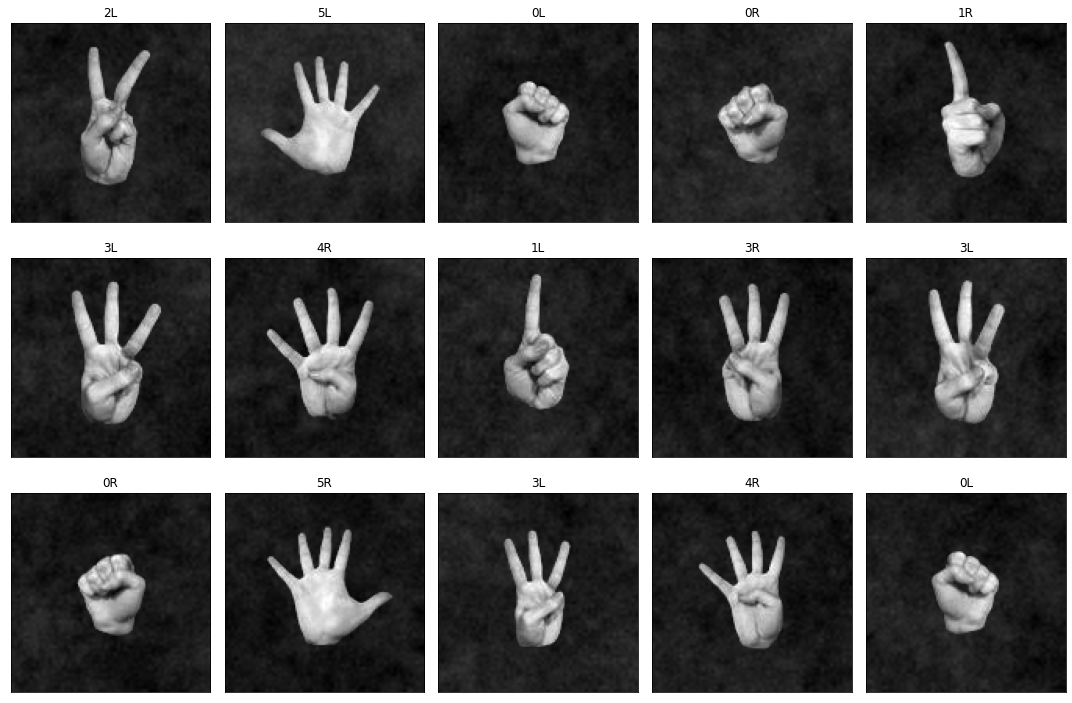

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]), cmap='gray')
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

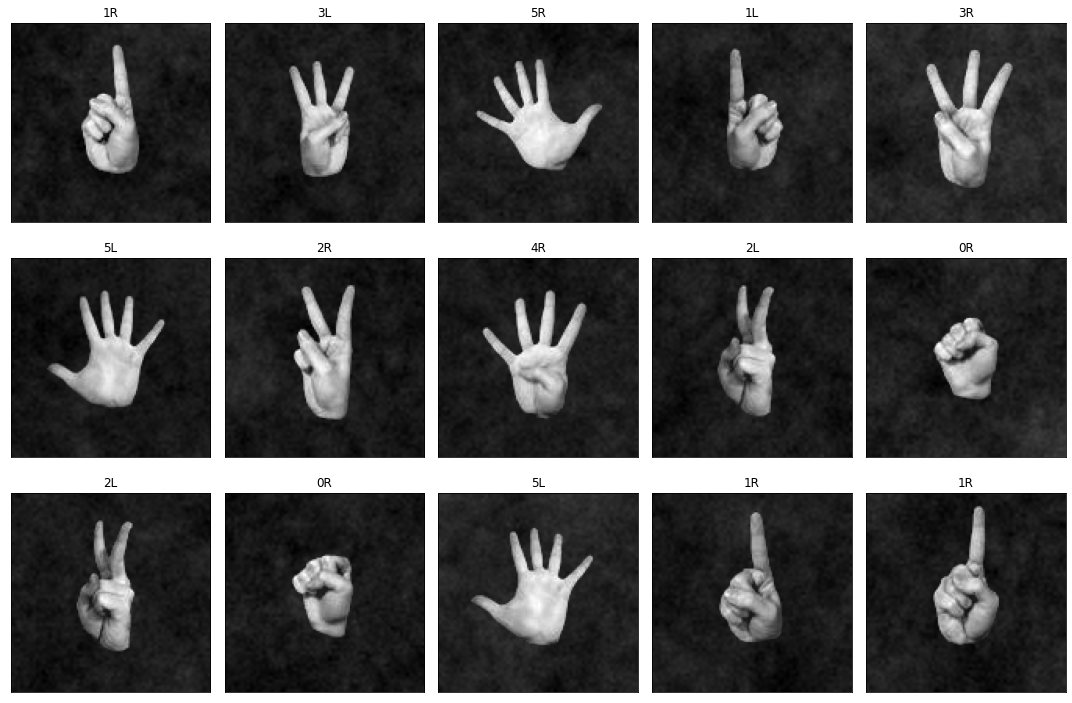

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap='gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input_VGG16,
    validation_split=0.1
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input_VGG16
)

train_images_flow = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training',
)

val_images_flow = train_generator.flow_from_dataframe( 
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation',

)

test_images_flow = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 15687 validated image filenames belonging to 12 classes.
Found 1743 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
feature_extractor = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

feature_extractor.trainable = False


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
classifier = Sequential([
    Dense(128, activation = 'relu'),
    Dense(12, activation ='softmax')
], name='Classifier')

In [ ]:
complete_model = Sequential([
    feature_extractor,
    classifier
], name='CompleteModel')


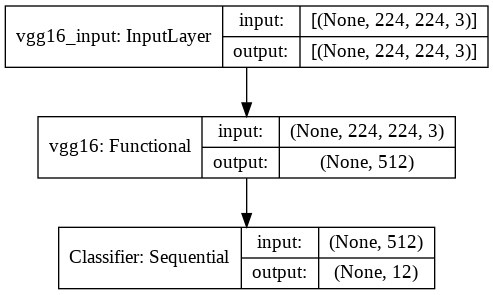

In [ ]:
tf.keras.utils.plot_model(complete_model, show_shapes=True)

In [ ]:
complete_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = complete_model.fit(
    train_images_flow,
    validation_data=val_images_flow,
    batch_size = 32,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/3
491/491 [==============================] - 2863s 6s/step - loss: 0.2938 - accuracy: 0.9113 - val_loss: 0.0573 - val_accuracy: 0.9880
Epoch 2/3
491/491 [==============================] - 134s 273ms/step - loss: 0.0293 - accuracy: 0.9952 - val_loss: 0.0167 - val_accuracy: 0.9977
Epoch 3/3
491/491 [==============================] - 134s 272ms/step - loss: 0.0143 - accuracy: 0.9973 - val_loss: 0.0132 - val_accuracy: 0.9989


In [ ]:
loss, acc = complete_model.evaluate(test_images_flow)

113/113 [==============================] - 572s 5s/step - loss: 0.0094 - accuracy: 0.9981


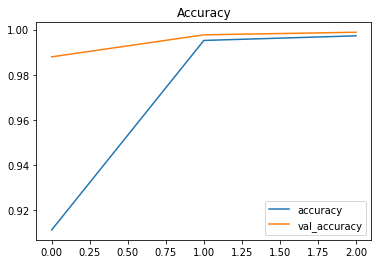

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

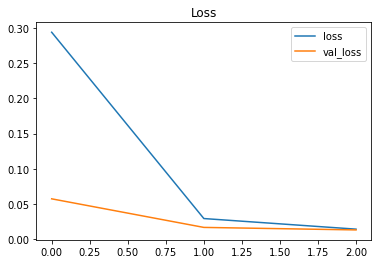

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
complete_model.save('/Dataset/MyDrive/Dataset/first_try2.h5')
# model.save('my_model.h5')

In [ ]:
from keras_preprocessing import image

img_pred = image.load_img('/Dataset/MyDrive/Dataset/train/1R/00a4ef2f-d6fe-49b9-acdf-c0d1092916da_1R.png',
                          target_size=(224, 224, 3))
img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = complete_model.predict(img_pred)
# print(result[0])
predicted_categories = tf.argmax(result, axis=1)
print(predicted_categories.numpy())

[3]


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_readable = le.fit_transform(train_df['Label'])

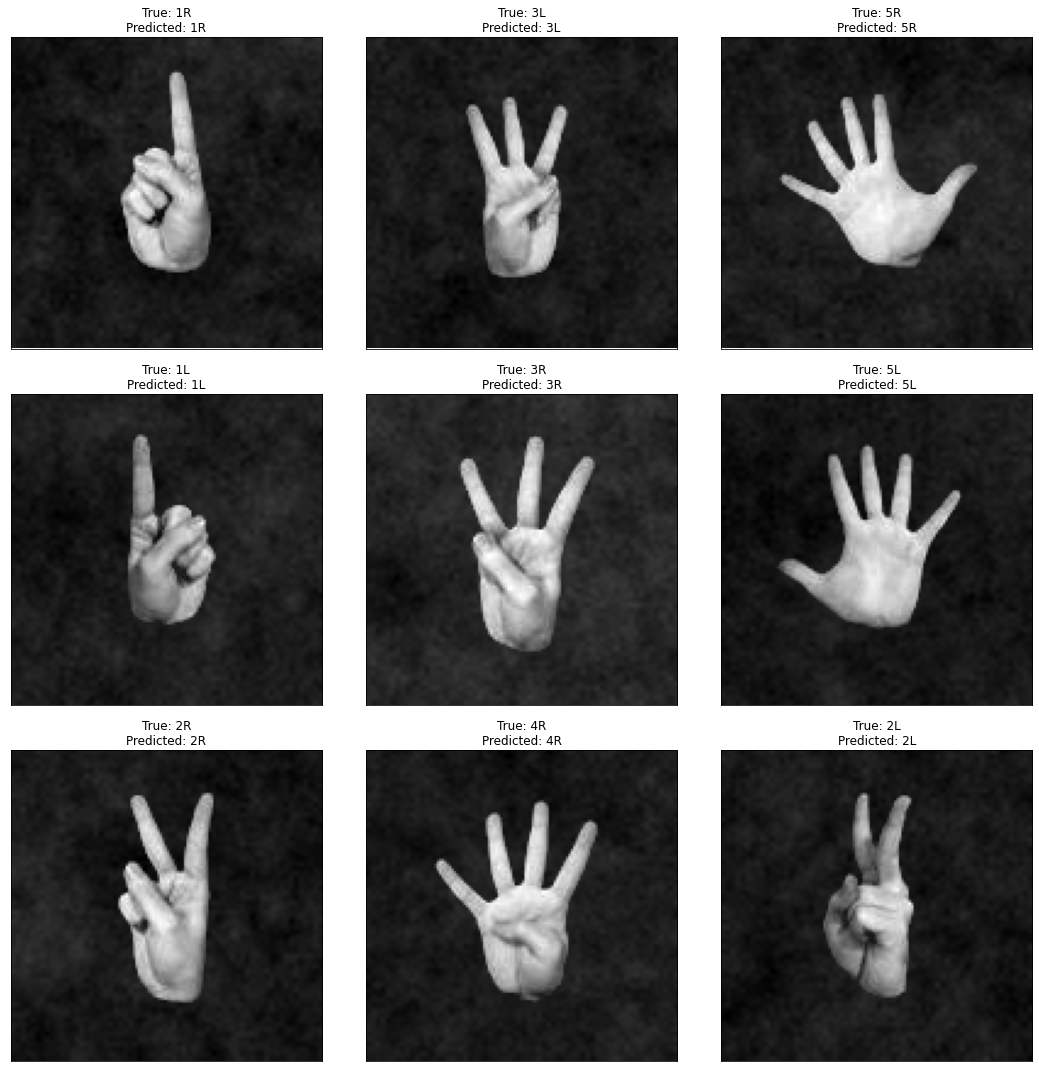

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

pred = complete_model.predict(test_images_flow)
pred = np.argmax(pred, axis=1)


for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]), cmap='gray')
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {le.inverse_transform([pred[i]])[0]}")
plt.tight_layout()
plt.show()